In [1]:
import math
import numpy as np 
import pandas as pd
import warnings
import pandas_datareader.data as web
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sloan-digital-sky-survey/Skyserver_SQL2_27_2018 6_51_39 PM.csv


In [3]:
df=pd.read_csv('../input/sloan-digital-sky-survey/Skyserver_SQL2_27_2018 6_51_39 PM.csv')

In [4]:
df.head(5)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [5]:
df['run'].value_counts()

756     3060
752     2086
1345     915
1350     540
1140     527
745      453
1035     396
1412     347
1302     246
1231     245
1331     245
1334     212
1239     197
1336     182
1404     137
1045     112
1402      49
308       31
1411      10
727        4
1356       4
1332       1
1119       1
Name: run, dtype: int64

In [6]:
df.shape

(10000, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [8]:
features=df.columns
for feature in features:
     print(f'{feature}--->{df[feature].nunique()}')

objid--->1
ra--->10000
dec--->10000
u--->9730
g--->9817
r--->9852
i--->9890
z--->9896
run--->23
rerun--->1
camcol--->6
field--->703
specobjid--->6349
class--->3
redshift--->9637
plate--->487
mjd--->355
fiberid--->892


In [9]:
df.describe().T.sort_values(ascending =0,by='mean').style.background_gradient(cmap='BuGn').bar(subset=['std'], color='red').bar(subset=['mean'], color='blue')

,count,mean,std,min,25%,50%,75%,max
specobjid,10000.000000,1645021569800000000.000000,2013998492866908672.000000,299578000000000000.000000,338924750000000000.000000,496658000000000000.000000,2881300000000000000.000000,9468830000000000000.000000
objid,10000.000000,1237650000000000000.000000,0.000000,1237650000000000000.000000,1237650000000000000.000000,1237650000000000000.000000,1237650000000000000.000000,1237650000000000000.000000
mjd,10000.000000,52943.533300,1511.150651,51578.000000,51900.000000,51997.000000,54468.000000,57481.000000
plate,10000.000000,1460.986400,1788.778371,266.000000,301.000000,441.000000,2559.000000,8410.000000
run,10000.000000,981.034800,273.305024,308.000000,752.000000,756.000000,1331.000000,1412.000000
fiberid,10000.000000,353.069400,206.298149,1.000000,186.750000,351.000000,510.000000,1000.000000
field,10000.000000,302.380100,162.577763,11.000000,184.000000,299.000000,414.000000,768.000000
rerun,10000.000000,301.000000,0.000000,301.000000,301.000000,301.000000,301.000000,301.000000
ra,10000.000000,175.529987,47.783439,8.235100,157.370946,180.394514,201.547279,260.884382
u,10000.000000,18.619355,0.828656,12.988970,18.178035,18.853095,19.259232,19.599900


In [10]:
df.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [11]:
df.drop_duplicates().sum()

objid                                12376499999999998820352.0
ra                                              1755299.865838
dec                                              148361.479842
u                                                 186193.55358
g                                                 173719.31487
r                                                 168409.63317
i                                                 165835.79249
z                                                  164228.3316
run                                                    9810348
rerun                                                  3010000
camcol                                                   36487
field                                                  3023801
specobjid                            16450215697999999270912.0
class        STARSTARGALAXYSTARSTARSTARGALAXYSTARSTARGALAXY...
redshift                                           1437.257118
plate                                                 1

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df['class'].unique()

array(['STAR', 'GALAXY', 'QSO'], dtype=object)

<AxesSubplot:>

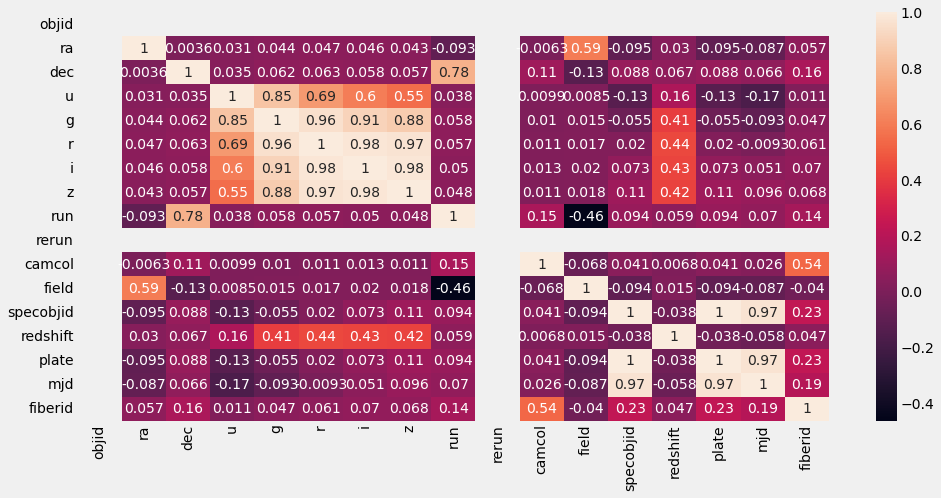

In [14]:
correl=df.corr()
fig = plt.figure(figsize=(15,7))
sns.heatmap(correl,annot=True)

<AxesSubplot:xlabel='class', ylabel='count'>

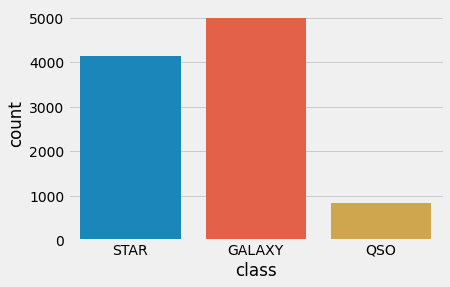

In [15]:
sns.countplot(x='class',data=df)

In [16]:
df.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [17]:
df.redshift.describe()

count    10000.000000
mean         0.143726
std          0.388774
min         -0.004136
25%          0.000081
50%          0.042591
75%          0.092579
max          5.353854
Name: redshift, dtype: float64

In [18]:
df.redshift.mean(),df.redshift.std()

(0.14372571182796998, 0.3887740358114659)

In [19]:
upperlimit =df.redshift.mean()+df.redshift.std()
lowerlimit =df.redshift.mean()-df.redshift.std()

In [20]:
df =df[(df.redshift>lowerlimit)&(df.redshift<upperlimit)]

In [21]:
df.shape

(9321, 18)

In [22]:
class1= df['class'].value_counts(ascending=False)
class1

GALAXY    4991
STAR      4152
QSO        178
Name: class, dtype: int64

In [23]:
df.groupby('class').count()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
class,,,,,,,,,,,,,,,,,
GALAXY,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991
QSO,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178
STAR,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152


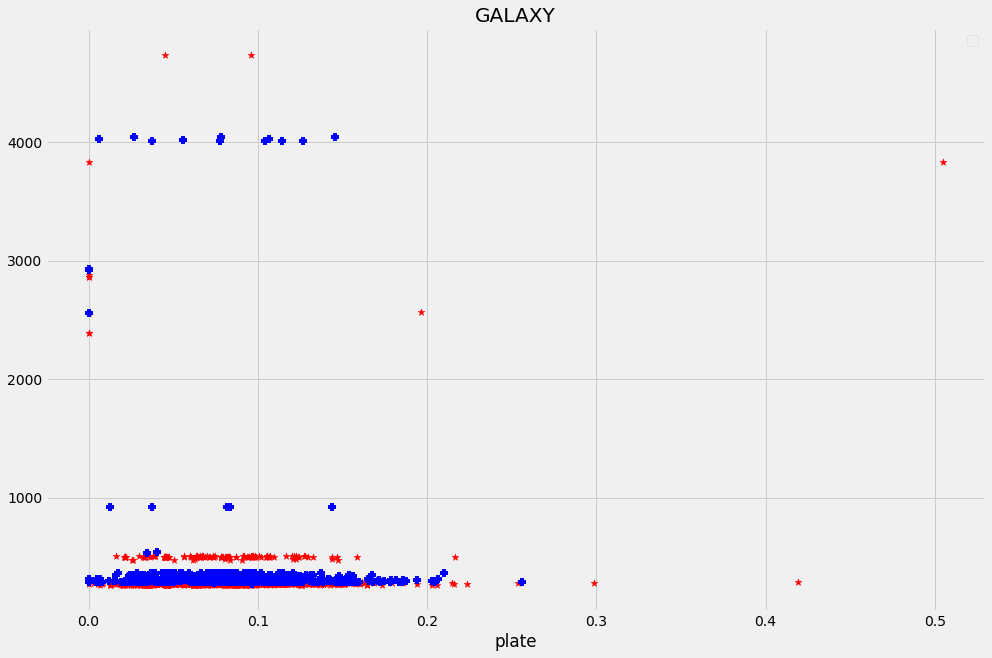

In [24]:
    
    local_1 = df[(df['class']=='GALAXY') & (df['run']==756)]
    local_2 =df[(df['class']=='GALAXY') & (df['run']==752)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(local_1.redshift,local_1.plate, color='red',marker='*', s=50)
    plt.scatter(local_2.redshift,local_2.plate, color='blue',marker='+', s=50)
    plt.xlabel("red shift")
    plt.xlabel("plate")    
    plt.title('GALAXY')
    plt.legend() 

In [25]:
field_1=df[df['class']=='STAR'].field
field_2=df[df['class']=='GALAXY'].field
field_3=df[df['class']=='QSO'].field


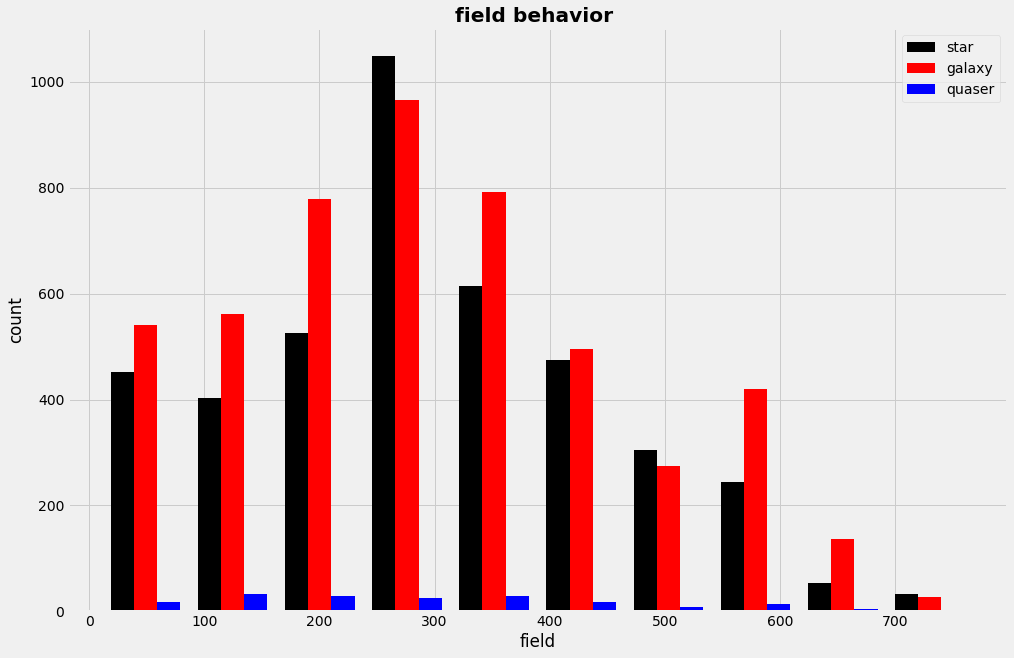

In [26]:
plt.xlabel('field')
plt.ylabel('count')
plt.hist([field_1,field_2,field_3], color=['black','red','blue'],label=['star','galaxy','quaser'])
plt.title('field behavior ',fontweight ="bold")
plt.legend()

In [27]:
df.replace({"class":{'STAR':0,'GALAXY':1,'QSO':2}},inplace=True)

In [28]:
df['class'].unique()

array([0, 1, 2])

In [29]:
df.head(5)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,0,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,0,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,1,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,0,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,0,0.000590,3306,54922,512


In [30]:
X=df.drop(['class'],axis='columns')
y=df['class']

In [31]:
X.drop('objid',inplace=True,axis=1)
X.drop('fiberid',inplace=True,axis=1)
X.drop('specobjid',inplace=True,axis=1)
X.drop('rerun',inplace=True,axis=1)
X.drop('camcol',inplace=True,axis=1)
X.drop('mjd',inplace=True,axis=1)

In [32]:
scaler = MinMaxScaler()
X= scaler.fit_transform(X)
X

array([[0.69383227, 0.07402547, 0.98096486, ..., 0.33817701, 0.00772845,
        0.37328094],
       [0.69409764, 0.07464221, 0.8582499 , ..., 0.33817701, 0.00764243,
        0.00699902],
       [0.69442156, 0.07451911, 0.96718767, ..., 0.33949802, 0.23828365,
        0.00257859],
       ...,
       [0.48809742, 0.77172401, 0.87267752, ..., 0.1994716 , 0.00699325,
        0.86407171],
       [0.48779894, 0.77288846, 0.89153871, ..., 0.2007926 , 0.03399714,
        0.02222495],
       [0.4885425 , 0.77359512, 0.9509842 , ..., 0.2007926 , 0.22949384,
        0.02222495]])

In [33]:
#data imbalance
from imblearn.over_sampling import SMOTE


In [34]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

1    4991
2    4991
0    4152
Name: class, dtype: int64

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm,test_size=0.2,random_state=5)

In [36]:
X_test.shape

(2827, 11)

# ******ML model

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [38]:
model_params = {           

    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
        }    
    },
       'XGB_Classifier':{
        'model':XGBClassifier(),
        'params':{
            'base_score':[0.5]
            
        }
    }, 
     
}


In [39]:
scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,random_forest,0.983908,{'n_estimators': 10}
1,logistic_regression,0.939699,{'C': 10}
2,decision_tree,0.975950,{'criterion': 'entropy'}
3,XGB_Classifier,0.990274,{'base_score': 0.5}


In [40]:
model=XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [41]:
model.score(X_test, y_test)

0.9929253625751681

In [42]:
y_train_predicted = model.predict(X_train)
y_train_predicted


array([1, 2, 1, ..., 0, 1, 0])

In [43]:
X_train

array([[7.26485189e-01, 9.76993102e-01, 8.65569595e-01, ...,
        2.32496697e-01, 2.49907837e-01, 2.81188605e-02],
       [6.33347465e-01, 7.74732506e-02, 9.60338431e-01, ...,
        3.62473615e-01, 6.78209778e-01, 1.54348069e-03],
       [5.74951255e-01, 7.17086067e-02, 7.85223864e-01, ...,
        3.18361955e-01, 1.76981124e-01, 6.13948919e-04],
       ...,
       [4.66328061e-01, 7.20461281e-01, 7.11942193e-01, ...,
        1.54557464e-01, 7.43941972e-03, 3.57072692e-01],
       [6.40958473e-01, 6.45074569e-02, 8.60903080e-01, ...,
        4.64993395e-01, 1.71967285e-01, 1.59626719e-03],
       [6.53499261e-01, 6.50669891e-02, 8.39555100e-01, ...,
        4.92734478e-01, 7.70815513e-03, 3.18762279e-01]])

In [44]:
y_predicted = model.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted)
cm

array([[862,   1,   0],
       [  3, 973,   9],
       [  0,   7, 972]])

Text(36.1, 0.5, 'Truth')

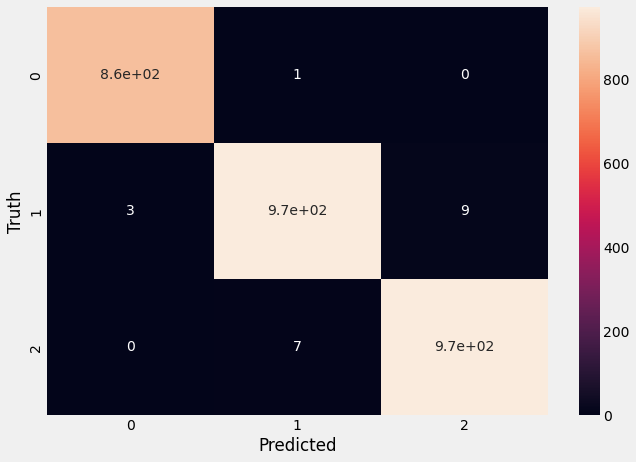

In [45]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [46]:
y_predicted

array([0, 1, 2, ..., 1, 1, 1])

In [48]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       0.99      0.99      0.99       985
           2       0.99      0.99      0.99       979

    accuracy                           0.99      2827
   macro avg       0.99      0.99      0.99      2827
weighted avg       0.99      0.99      0.99      2827



In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predicted)

0.9929253625751681

In [50]:
y_test.shape


(2827,)

In [51]:
y_predicted.shape

(2827,)

In [53]:
mse = mean_squared_error(y_test,y_predicted)
print(f'{mean_squared_error}: {mse}')

<function mean_squared_error at 0x7fea68eda7a0>: 0.007074637424831978
